In [1]:
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import time;
import os
import numpy as np
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt

In [40]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets


# Loading and normalizing the data.
# Define transformations for the training and test sets

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

data_dir = 'ultimate_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) 
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

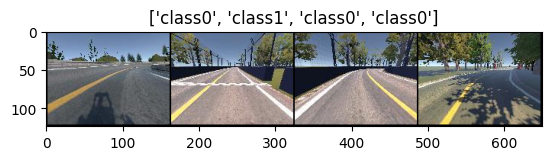

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [3]:
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            print(phase)
            label0=0
            label1=0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                for i in labels:
                    if i==0:
                        label0+=1
                    else:
                        label1+=1
                        
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            print("label0:",label0)
            print("label1:",label1)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val test: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [72]:
import torch.optim as optim
from torch.optim import lr_scheduler

model_test = models.resnet18(pretrained=True)
num_ftrs = model_test.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_test.fc = nn.Linear(num_ftrs, 2)

model_test = model_test.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_test.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [73]:
model_test = train_model(model_test, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train
label0: 838
label1: 302
train Loss: 0.1988 Acc: 0.9263
test
label0: 291
label1: 67
test Loss: 0.0505 Acc: 0.9972

Epoch 1/4
----------
train
label0: 838
label1: 302
train Loss: 0.0723 Acc: 0.9851
test
label0: 291
label1: 67
test Loss: 0.5402 Acc: 0.7430

Epoch 2/4
----------
train
label0: 838
label1: 302
train Loss: 0.1102 Acc: 0.9711
test
label0: 291
label1: 67
test Loss: 0.0508 Acc: 0.9888

Epoch 3/4
----------
train
label0: 838
label1: 302
train Loss: 0.0153 Acc: 0.9965
test
label0: 291
label1: 67
test Loss: 0.1067 Acc: 0.9497

Epoch 4/4
----------
train
label0: 838
label1: 302
train Loss: 0.0043 Acc: 1.0000
test
label0: 291
label1: 67
test Loss: 0.0640 Acc: 0.9777

Training complete in 3m 18s
Best val test: 0.997207


In [96]:
"""
model_saved = model_test.to('cpu')
torch.save(model_saved.state_dict(), "BEST_MODEL3.pt")
"""

torch.save(model_test, "Hole_Model.pth")


In [98]:
validation_set = datasets.ImageFolder(root = "validation_dataset", 
                                  transform = data_transforms["test"])

# Create a loader for the test set which will read the data within batch size and put into memory. 
# Note that each shuffle is set to false for the test loader.
validation_loader = DataLoader(validation_set, batch_size=10, shuffle=False, num_workers=0)

def validationBatch(model):
    # get batch of images from the test DataLoader  
    total_count=0
    success1=0
    wrong1=0
    success0=0
    wrong0=0
    for i, (images, labels) in enumerate(validation_loader, 0):
            # get the inputs
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)   
            _, predicted = torch.max(outputs, 1)
            for j in range(len(predicted)):
                if predicted[j]==labels[j]:
                    if predicted[j]==0:
                        total_count+=1
                        success0+=1
                    else:
                        total_count+=1
                        success1+=1
                else:
                    if labels[j]==0:
                        total_count+=1
                        wrong0+=1
                    else:
                        total_count+=1
                        wrong1+=1
                    

    print("total count: ",total_count)
    print("success1: ",success1)
    print("wrong1: ", wrong1)
    print("success0:", success0)
    print("wrong0: ",wrong0)

   
    # Show the real labels on the screen 
    print("Reality: ",labels)
    
    # Let's see what if the model identifiers the  labels of those example
    # We got the probability for every 10 labels. The highest (max) probability should be correct label

    print("Predicted",predicted)
    
    # Let's show the predicted labels on the screen to compare with the real ones

    

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)
model = model.to('cpu')

path = "Hole_Model.pth"
model = torch.load(path)
model.to(device)
validationBatch(model)

total count:  65
success1:  25
wrong1:  0
success0: 40
wrong0:  0
Reality:  tensor([1, 1, 1, 1, 1], device='cuda:0')
Predicted tensor([1, 1, 1, 1, 1], device='cuda:0')
